In [1]:
import nltk
import pandas as pd
import numpy as np
import os
import majka
from ast import literal_eval
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

from parser import parse_xml_file
from stop_words import get_stop_words
from string_helper import replace_string_with_pattern, clear_empty_string, decode_html_chars

In [2]:
# Configuration
DEBUG = True

if (DEBUG):
    pd.set_option('display.max_rows', 500)
    pd.set_option('display.width', 1000)

try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

# Stopwords
stop_words = get_stop_words('cz')
# Extended with custom (those are missing from official stop_words package)
stop_words.extend(['a','v','vo','na','k','u','i','zo','z','so','s',])

# Czech lemmatizer Majka
morph = majka.Majka('../wordlists/majka.w-lt')
morph.flags |= majka.ADD_DIACRITICS  # Find word forms with diacritics
morph.flags |= majka.DISALLOW_LOWERCASE  # Do not enable to find lowercase variants
morph.flags |= majka.IGNORE_CASE  # Ignore the word case whatsoever
morph.flags = 0  # Unset all flags
morph.tags = False  # Return just the lemma
morph.first_only = True  # Return only the first entry

# Histogram of unlemmatizable words
unlemmatizable_tokens_histogram = {}
# Treshold of occurrences of unlemmatizable tokens, below which the tokens won't be added to the result
unlemmatizable_tokens_threshold = 2

In [3]:
# Load file paths
xml_file_path = '../data/test.xml' if DEBUG else '../data/cswiki-latest-pages-articles.xml'
parsed_file_path = '../data/out-parsed.csv'
tokenized_file_path = '../data/out-tokenized.csv'
lemmatized_file_path = '../data/out-lemmatized.csv'

In [4]:
# Remove files if exists (because we'll append to them)
for filePath in [parsed_file_path,tokenized_file_path,lemmatized_file_path]:
    if os.path.exists(filePath):
        os.remove(filePath)

In [5]:
# Parse input file line by line 
parse_xml_file(xml_file_path, parsed_file_path)

In [6]:
def clear_data(dataframe):
    for col in dataframe:
        dataframe[col] = dataframe[col]\
        .apply(lambda x: x if x is not np.NaN else None) \
        .apply(replace_string_with_pattern,pattern=r"[\\/:.,\-_#()?“„ ]+|{.*}",replace_with=' ') \
        .apply(replace_string_with_pattern,pattern=r"&amp;",replace_with='&') \
        .apply(decode_html_chars) \
        .apply(lambda x: str(x) if isinstance(x, int) or isinstance(x,float) else x) \
        .apply(clear_empty_string)

    return dataframe

In [7]:
def tokenize(dataframe):
    for col in dataframe:
        dataframe[col] = dataframe[col]\
            .apply(lambda data: nltk.tokenize.word_tokenize(data) if data is not None or not np.nan else [])\
            .apply(lambda tokens: [token.lower() for token in tokens if not token in stop_words])
    return dataframe

In [8]:
def add_unlemmatizable_words(dataframe,histogram):
    for col in dataframe:
        for row in dataframe[col]:
            for word in row:
                if not (morph.find(word)):
                    if word in histogram:
                        histogram[word] = histogram[word]+1 if histogram[word] < unlemmatizable_tokens_threshold else histogram[word]
                    else:
                        histogram[word] = 1

In [9]:
def lemmatize(dataframe):
    for col in dataframe:
        # Lemmatize token (preserve unlemmatizable tokens according to threshold)
        dataframe[col] = dataframe[col]\
            .apply(lambda tokens: [y for token in literal_eval(tokens) if (y := (morphed_token[0]['lemma'] if (morphed_token := morph.find(token)) else token if unlemmatizable_tokens_histogram[token] >= unlemmatizable_tokens_threshold else None)) is not None])
    return dataframe

In [10]:
# Tokenize parsed file chunk by chunk
for chunk in pd.read_csv(parsed_file_path,sep=",",header=None,names=['0','1'],encoding='UTF-8',chunksize=50):
    chunk = clear_data(chunk)
    chunk = tokenize(chunk)
    # Creates histogram of not lemmatizable tokens
    add_unlemmatizable_words(chunk,unlemmatizable_tokens_histogram)
    chunk.to_csv(tokenized_file_path, mode='a+', header=False, index=False,encoding='UTF-8')

In [11]:
# Lemmatize Tokens chunk by chunk
for chunk in pd.read_csv(tokenized_file_path,sep=",",header=None,names=['0','1'],encoding='UTF-8',chunksize=50):
    chunk = lemmatize(chunk)
    chunk.to_csv(lemmatized_file_path, mode='a+', header=False, index=False,encoding='UTF-8')

In [12]:
total_counter = 0
lemmatized_counter = 0

def count_lemmas(lemmatized):
    global lemmatized_counter, total_counter
    for lemma in literal_eval(lemmatized):
        total_counter+=1
        if not lemma in unlemmatizable_tokens_histogram:
            lemmatized_counter+=1

# Read lemmatized words and count them
data = pd.read_csv(lemmatized_file_path,sep=",",header=None,names=['0','1'],encoding='UTF-8')   
for col in data:
    data[col].apply(count_lemmas)

In [13]:
# Otazky:
# ratat originalne slova alebo vsetky? (pretiekla nam pamat pri udrziavani originalnov + counter v hashmape)
# my zapisujeme do toho lemmatized suboru aj tie ktore su nad tresholdom, mame pri celkovom pocte nejako tieto odratat?

In [14]:
print(f"The number of lemmatized words in {lemmatized_file_path}: {lemmatized_counter}")

The number of lemmatized words in ../data/out-lemmatized.csv: 655


In [15]:
# Otazky:
# graf occurences (Y slov ma X occurences)
df_histogram = pd.DataFrame({'lemma': list(unlemmatizable_tokens_histogram.keys()),'count':list(unlemmatizable_tokens_histogram.values())})

Text(0.5, 0, 'Number of lemma occurences')

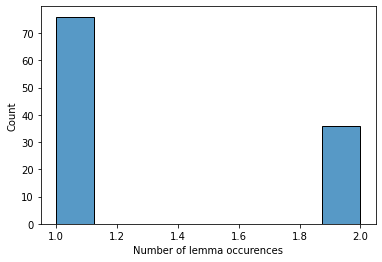

In [16]:
sns.histplot(df_histogram['count'])
plt.xlabel('Number of lemma occurences')

/Users/feri/.local/share/virtualenvs/VINF-P9TXDHeq/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='count'>

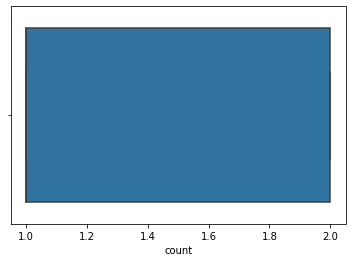

In [17]:
sns.boxplot(df_histogram['count'])

In [18]:
def use_quantiles(df, column):
    new_df = df.copy(deep = True)
    skew_val = stats.skew(new_df[column]) 
    
    if ((skew_val < -2) or (skew_val > 2)):  
        minimum = new_df[column].min()
        minimum = minimum + (-minimum - minimum)
        new_df[column] = np.log(new_df[column]+minimum)
    
    perc_95 = new_df[column].quantile(.95)   
    perc_05 =  new_df[column].quantile(.05)
    new_df.loc[new_df[column] < perc_05, column] = perc_05
    new_df.loc[new_df[column] > perc_95, column] = perc_95
    return new_df

In [19]:
df_histogram = use_quantiles(df_histogram, 'count')

Text(0.5, 0, 'Number of lemma occurences')

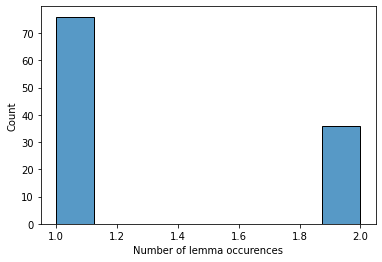

In [20]:
sns.histplot(df_histogram['count'])
plt.xlabel('Number of lemma occurences')

/Users/feri/.local/share/virtualenvs/VINF-P9TXDHeq/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='count'>

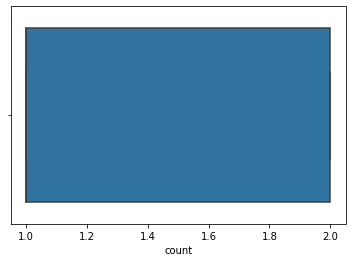

In [21]:
sns.boxplot(df_histogram['count'])